![](http://www.kiplinger.com/kipimages/pages/14024.jpg)

# An Extensive Medicare Data Exploration - Healthcare Analysis

## About Medicare 

In the United States, Medicare is a single-payer, national social insurance program administered by the U.S. federal government since 1966. United States Medicare is funded by a payroll tax, premiums and surtaxes from beneficiaries, and general revenue. It provides health insurance for Americans aged 65 and older who have worked and paid into the system through the payroll tax. It also provides health insurance to younger people with some disability status as determined by the Social Security Administration, as well as people with end stage renal disease and amyotrophic lateral sclerosis.

In 2015, Medicare provided health insurance for over **55 million** (46 million people age 65 and older and 9 million younger people). On average, Medicare covers about half of the health care charges for those enrolled. The enrollees must then cover their remaining costs either with supplemental insurance, separate insurance, or out-of-pocket. Out-of-pocket costs can vary depending on the amount of health care a Medicare enrollee needs. 

## About CMS

The Centers for Medicare & Medicaid Services (CMS), previously known as the Health Care Financing Administration (HCFA), is a federal agency within the United States Department of Health and Human Services (HHS) that administers the Medicare program and works in partnership with state governments to administer Medicaid, the Children's Health Insurance Program (CHIP), and health insurance portability standards. In addition to these programs, CMS has other responsibilities, including the administrative simplification standards from the Health Insurance Portability and Accountability Act of 1996 (HIPAA), quality standards in long-term care facilities (more commonly referred to as nursing homes) through its survey and certification process, clinical laboratory quality standards under the Clinical Laboratory Improvement Amendments, and oversight of HealthCare.gov.

## About the Data-Set

This [public dataset](https://www.kaggle.com/cms/cms-medicare) was created by the Centers for Medicare & Medicaid Services. The data summarizes the utilization and payments for procedures, services, and prescription drugs provided to Medicare beneficiaries by specific inpatient and outpatient hospitals, physicians, and other suppliers. The dataset includes the following data: Common inpatient and outpatient services, All physician and other supplier procedures and services, All Part D prescriptions. Providers determine what they will charge for items, services, and procedures provided to patients and these charges are the amount that providers bill for an item, service, or procedure.

In this notebook, I have explored the complete dataset using BigQuery, performed clustering on nursing facilities data to identify groups of nursing facilities having similar characteristics

## Contents

1. States having more nursing facilities  
2. HCC Scores - Which State and Which facilities have poor HCC scores  
&nbsp;&nbsp;&nbsp;&nbsp;  2.1 Max and Min HCC Scores for different States   
&nbsp;&nbsp;&nbsp;&nbsp;  2.2 Average HCC scores for different States  
&nbsp;&nbsp;&nbsp;&nbsp;  2.3 Facilities with High HCC scores  
&nbsp;&nbsp;&nbsp;&nbsp;  2.4 Facilities with Low HCC Scores
   
3. Beneficiary Gender    
&nbsp;&nbsp;&nbsp;&nbsp;  3.1 States having more male beneficiaries than female beneficiaries      
&nbsp;&nbsp;&nbsp;&nbsp;  3.2 States and the difference in male and femal beneficiaries    
&nbsp;&nbsp;&nbsp;&nbsp;  3.3 Difference in Average Inpatient and Outpatient payments   

4. Which state has the largest number of stay days  
&nbsp;&nbsp;&nbsp;&nbsp;  4.1 States and their Average Total Stays (of different facilities) and Average length of stays    
&nbsp;&nbsp;&nbsp;&nbsp;  4.2  Facilities having highest average length of stay days  

5. Total Claims, Day Supply and Drug Costs  
&nbsp;&nbsp;&nbsp;&nbsp;  5.1 States having highest claims, supply, and cost      
&nbsp;&nbsp;&nbsp;&nbsp;  5.2 Drugs having highest claims, supply and cost      
&nbsp;&nbsp;&nbsp;&nbsp;  5.3 Nursing Specialities having highest claims, supply, and cost      
&nbsp;&nbsp;&nbsp;&nbsp;  5.4 Most prescribed Drug of each state    
   
6. Clustering the Nursing Facilities   
&nbsp;&nbsp;&nbsp;&nbsp;    6.1 Applying K-Means Clustering to obtain Groups  
&nbsp;&nbsp;&nbsp;&nbsp;    6.2 Exploring the Nursing Facilities Clusters  
&nbsp;&nbsp;&nbsp;&nbsp;    6.3 Mean Comparisons of Key Features  
&nbsp;&nbsp;&nbsp;&nbsp;    6.4 Distribution of Key Features  
&nbsp;&nbsp;&nbsp;&nbsp;    6.5 Inference about different Groups of Nursing Facilities  



## Contents
1. Cost Analysis:
* What are the average inpatient charges across different states or regions?
* Are there any trends or patterns in inpatient charges over the years?    


In [2]:
# Import the required libraries 

from bq_helper import BigQueryHelper
import bq_helper

from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

medicare = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="cms_medicare")
bq_assistant = BigQueryHelper("bigquery-public-data", "cms_medicare")

## Cost Analysis - Anubha 

### 1. Cost Analysis:
* What are the average inpatient charges across different states or regions?
* Are there any trends or patterns in inpatient charges over the years?    

In [3]:
query_state_avg = """SELECT
provider_state, sum(average_covered_charges) AS Count FROM
  `bigquery-public-data.cms_medicare.inpatient_charges_2015`
  group by provider_state
  ORDER BY Count DESC;"""
response1 = medicare.query_to_pandas_safe(query_state_avg)

In [5]:
response1


'SELECT\nprovider_state, sum(average_covered_charges) AS Count FROM\n  `bigquery-public-data.cms_medicare.inpatient_charges_2015`\n  group by provider_state\n  ORDER BY Count DESC;'

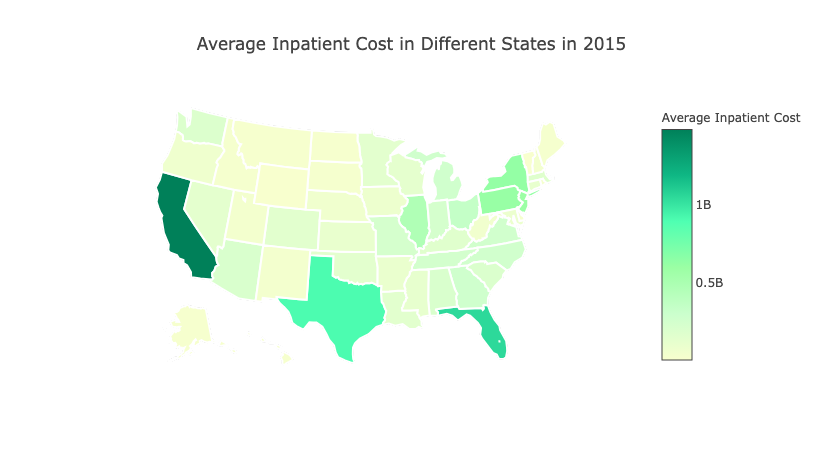

In [8]:
scl = [[0.0, 'rgb(248,255,206)'],[0.2, 'rgb(203,255,205)'],[0.4, 'rgb(155,255,164)'], [0.6, 'rgb(79,255,178)'],[0.8, 'rgb(15,183,132)'], [1, '#008059']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = response1.provider_state,
        z = response1.Count,
        locationmode = 'USA-states',
        text = response1.provider_state,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Average Inpatient Cost")
        )
       ]
layout = dict(
        title = 'Average Inpatient Cost in Different States in 2015',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

In [42]:
# checking for US average in 2015 and seeing how many states fall above the median
query_state_above_avg = """WITH StateSums AS (
  SELECT
    provider_state,
    SUM(average_covered_charges) AS StateSum
  FROM
    `bigquery-public-data.cms_medicare.inpatient_charges_2015`
  GROUP BY
    provider_state
),

RankedSums AS (
  SELECT
    provider_state,
    StateSum,
    PERCENTILE_CONT(StateSum, 0.5) OVER () AS Median
  FROM
    StateSums
)

SELECT
  COUNTIF(StateSum > Median) / COUNT(*) * 100 AS percent_above_median
FROM
  RankedSums;


"""
response2 = medicare.query_to_pandas_safe(query_state_above_avg)

In [43]:
response2

,percent_above_median
0,49.019608


## Inferences:

CA followed by FL has the heighest average inpatient cost in 2015. 49.01% states are above the median costs.

## Anomaly Detection
* Can you identify any outliers or anomalies in the data, such as unusually high or low inpatient charges?

In [15]:
query_anomoly = """WITH Stats AS (
  SELECT
    AVG(average_covered_charges) AS avg_covered_charges,
    STDDEV(average_covered_charges) AS std_dev_covered_charges,
    AVG(average_total_payments) AS avg_total_payments,
    STDDEV(average_total_payments) AS std_dev_total_payments,
    AVG(average_medicare_payments) AS avg_medicare_payments,
    STDDEV(average_medicare_payments) AS std_dev_medicare_payments
  FROM
    `bigquery-public-data.cms_medicare.inpatient_charges_2015`
)

SELECT
  provider_state,
  average_covered_charges,
  average_total_payments,
  average_medicare_payments
FROM
  `bigquery-public-data.cms_medicare.inpatient_charges_2015`,
  Stats
WHERE
  ABS(average_covered_charges - Stats.avg_covered_charges) > 5 * Stats.std_dev_covered_charges
  OR ABS(average_total_payments - Stats.avg_total_payments) > 5 * Stats.std_dev_total_payments
  OR ABS(average_medicare_payments - Stats.avg_medicare_payments) > 5 * Stats.std_dev_medicare_payments;
"""
response_anomoly = medicare.query_to_pandas_safe(query_anomoly)

In [16]:
response_anomoly

,provider_state,average_covered_charges,average_total_payments,average_medicare_payments
0,MA,264556.0,155668.0,155041.0
1,MA,134518.0,99350.0,81412.0
2,MA,139147.0,82873.0,82133.0
3,MA,133278.0,88298.0,85616.0
4,MA,213652.0,74480.0,73329.0
5,MA,462916.0,191982.0,174743.0
6,MA,263105.0,107825.0,99977.0
7,MA,392745.0,120883.0,112899.0
8,MA,215623.0,87683.0,85781.0
9,MA,220287.0,77750.0,73352.0


## state with maximum anomalies


In [17]:
state_counts = response_anomoly['provider_state'].value_counts()

# Find the state with the maximum number of rows
max_rows_state = state_counts.idxmax()

print("State with the maximum number of rows:", max_rows_state)

State with the maximum number of rows: CA


## Inference:
CA has maximum number of anlomalies 

## Procedure-Specific Analysis: 
* What are the most common inpatient procedures, and how much do they cost on average?

In [44]:
query_procedures = """
SELECT * FROM (
    SELECT '2015' as year, 
        drg_definition, COUNT(*) as Count 
    FROM `bigquery-public-data.cms_medicare.inpatient_charges_2015`
    GROUP BY year, drg_definition
    ORDER BY Count DESC
    LIMIT 5
)
UNION ALL
SELECT * FROM (
    SELECT '2014' as year,
        drg_definition, COUNT(*) as Count 
    FROM `bigquery-public-data.cms_medicare.inpatient_charges_2014`
    GROUP BY year, drg_definition
    ORDER BY Count DESC
    LIMIT 5
)
UNION ALL
SELECT * FROM (
    SELECT '2013' as year,
        drg_definition, COUNT(*) as Count 
    FROM `bigquery-public-data.cms_medicare.inpatient_charges_2013`
    GROUP BY year, drg_definition
    ORDER BY Count DESC
    LIMIT 5
)
UNION ALL
SELECT * FROM (
    SELECT '2012' as year,
        drg_definition, COUNT(*) as Count 
    FROM `bigquery-public-data.cms_medicare.inpatient_charges_2012`
    GROUP BY year, drg_definition
    ORDER BY Count DESC
    LIMIT 5
)
UNION ALL
SELECT * FROM (
    SELECT '2011' as year,
        drg_definition, COUNT(*) as Count 
    FROM `bigquery-public-data.cms_medicare.inpatient_charges_2011`
    GROUP BY year, drg_definition
    ORDER BY Count DESC
    LIMIT 5
);

  """
response_proc = medicare.query_to_pandas_safe(query_procedures)

In [45]:
response_proc

,year,drg_definition,Count
0,2012,194 - SIMPLE PNEUMONIA & PLEURISY W CC,2968
1,2012,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,2896
2,2012,292 - HEART FAILURE & SHOCK W CC,2875
3,2012,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",2855
4,2012,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,2790
5,2013,194 - SIMPLE PNEUMONIA & PLEURISY W CC,2953
6,2013,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,2819
7,2013,292 - HEART FAILURE & SHOCK W CC,2802
8,2013,690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC,2794
9,2013,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",2790


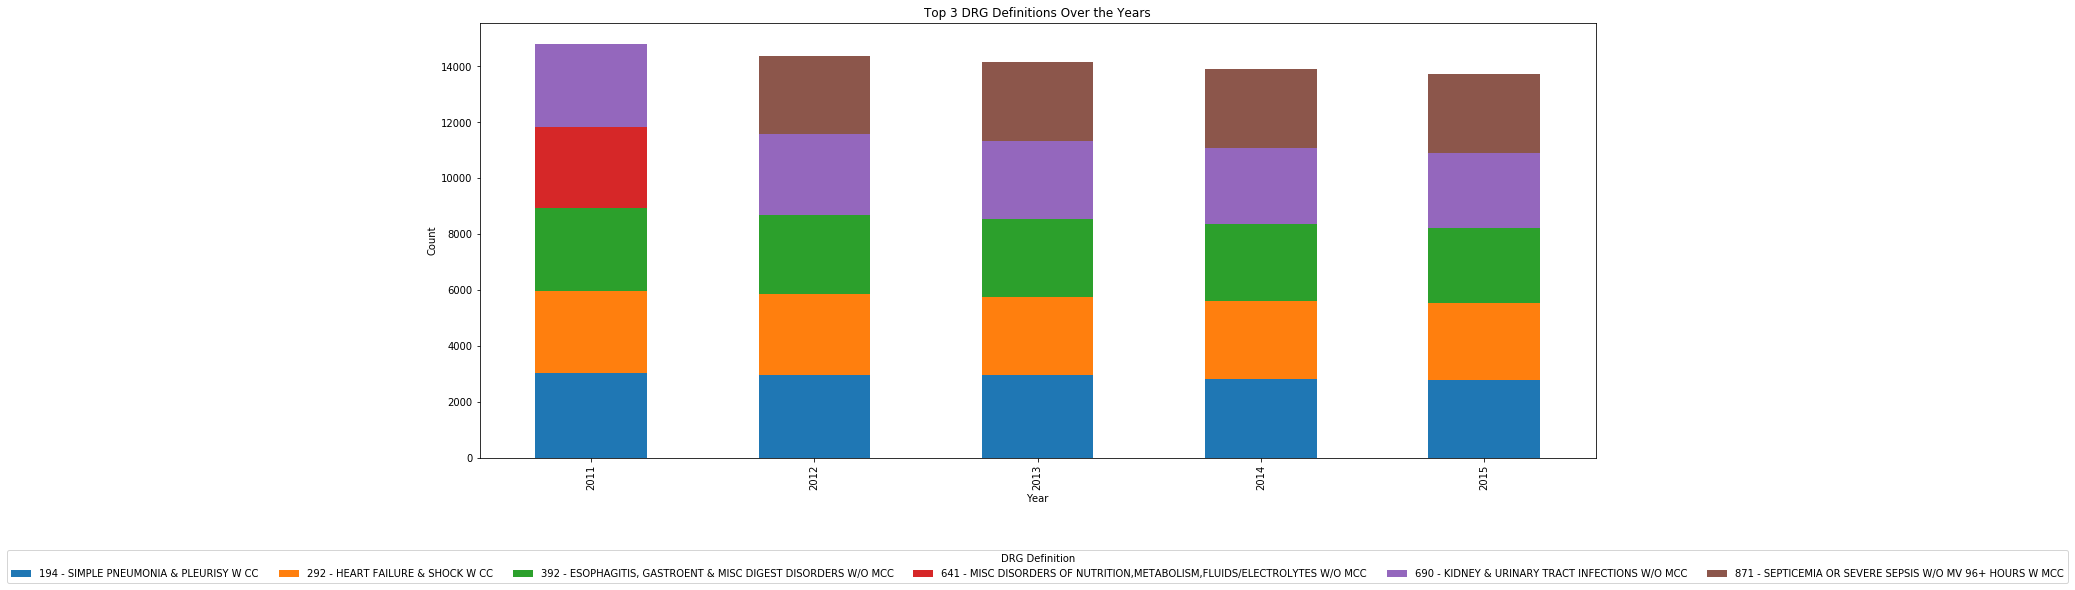

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named response_proc
# Replace 'Count', 'year', and 'drg_definition' with your actual column names

pivot_df = response_proc.pivot(index='year', columns='drg_definition', values='Count')

# Set a larger figure size
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the data
pivot_df.plot(kind='bar', stacked=True, ax=ax)

plt.title('Top 3 DRG Definitions Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')

# Move the legend to the bottom and outside the plot
plt.legend(title='DRG Definition', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(pivot_df.columns))

plt.show()


Only 2011 has MISC Disorders which is in the top 5 disorders. We see in 2012 - 2015 we see the top 5 procedures remain the same.